In [2]:
import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
from scipy.ndimage import gaussian_filter

In [3]:
#compare cosmolike
clike_dir = '../datafiles/cosmolike_srd/'
lss_y1_cosmolike = np.loadtxt(clike_dir+'datav/pos_pos_Y1_fid')
lss_y1_ell = np.loadtxt(clike_dir+'ell-values')

In [6]:
def lsst_srd_galaxy_clustering_2pt(cosmo, year):
    # cosmo is a ccl cosmology object
    # binning etc is set to 5 z bins for y1 (10 for y10) and 20 ell bins with cutoff at high ell like in the SRD and Tim's cosmoliek code
    if year=='Y1' or year==1 or year=='y1':
        nbin_z = 5
        z0 = 0.26
        alpha = 0.94
        sig_z = 0.03
        Ngal = 18 # Normalisation, galaxies/arcmin^2
        linear_bias = np.array([1.562362, 1.732963, 1.913252, 2.100644, 2.293210])
    else:
        print('only Y1 implemented currently')
        
    bin_edges = np.linspace(0.2, 1.2, nbin_z+1)
    bin_low_zs = bin_edges[:-1]
    bin_high_zs = bin_edges[1:]
    zmids = (bin_low_zs+bin_high_zs)/2
        
    nbin_ell = 20 
    lmin = 20
    lmax = 15000
    ell_edges = np.geomspace(lmin, lmax, nbin_ell+1)
    ell_centers = [lmin**(1-(i+0.5)/nbin_ell)*lmax**((i+0.5)/nbin_ell) for i in range(nbin_ell)]
    print(ell_edges)
    print(lss_y1_ell)
    
    plt.plot((ell_centers-lss_y1_ell)/lss_y1_ell, '.')
    plt.title('fractional difference in $\ell$ centers compared to DESC SRD')
    plt.show()
    
    chis = ccl.comoving_radial_distance(cosmo, 1/(1+zmids)) # Mpc
    kmax = 0.3*h
    lmax = kmax*chis-0.5
    
    z= np.linspace(0., 3., 1001)
    #redshift distribution normalized to galaxy number density
    pz = (z / z0)**2. * np.exp(-(z / z0)**alpha) # Redshift distribution, p(z)
    norm = Ngal/np.trapz(pz, z)
    nz = norm * pz # Number density distribution
    
    tracers = []
    b_mag = np.zeros(len(z))
    for i, zmin in enumerate(bin_low_zs):
        zmax = bin_high_zs[i]
        zmid = zmids[i]
        nz_bin = np.zeros_like(z)
        nz_bin[(z>zmin) & (z<zmax)] = nz[(z>zmin) & (z<zmax)]
        dz = z[1]-z[0]
        nz_bin = gaussian_filter(nz_bin, sig_z*(1+zmid)/dz)
    
        # galaxy clustering CCL tracer for computing mock datavector
        galaxy_tracer_bin = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz_bin), bias=(z,linear_bias[i]*np.ones(len(z))), mag_bias=None)
        tracers.append(galaxy_tracer_bin)
    
    ell = np.arange(0, 20000)
    # assuming tophat ell binning
    datavector = np.zeros((nbin_ell*nbin_z, 2))
    for i in range(nbin_z):
        datavector[0:10]
        datavector[0:100]
        cl_zbin = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell)
        # use Limber once it is implemented
#         cl_zbin_nonlimber = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell, l_limber=200)
#         plt.loglog(ell, cl_zbin, label='limber')
#         plt.loglog(ell, cl_zbin_nonlimber, label='nonlimber')
#         plt.show()
        num_lbins_linear_scales = np.sum(ell_centers<lmax[i]) #from kmax=0.3 h / Mpc criterion    
        for j, ell_j in enumerate(ell_centers):
            datavector[i*nbin_ell+j, 0]=ell_j
            if ell_j<lmax[i]:
                datavector[i*nbin_ell+j, 1] = np.mean(cl_zbin[(ell>=ell_edges[j]) & (ell<=ell_edges[j+1])])
    return datavector

[   20.            27.84729778    38.77359967    53.9869988
    75.16960158   104.66351394   145.72980195   202.90905949
   282.52345005   393.37573211   547.72255751   762.62965788
  1061.85875879  1478.49485262  2058.60432107  2866.32837661
  3990.97499139  5556.89345013  7737.22333081 10773.0381027
 15000.        ]
[   23.5997     32.8594     45.75227    63.70386    88.69901   123.5014
   171.959     239.4297    333.3735    464.1775    646.3045    899.8917
  1252.978    1744.602    2429.122    3382.225    4709.291    6557.052
  9129.808   12712.02   ]


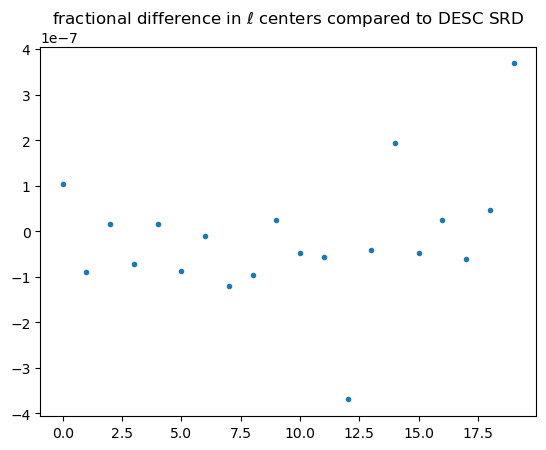

Text(0.5, 1.0, 'Galaxy clustering C($\\ell$) for 5 redshift bins (LSST Y1)')

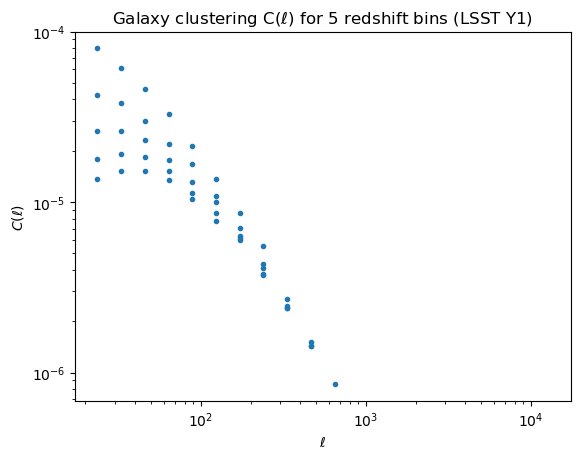

In [7]:
h=0.6727
cosmo_fid_srd = ccl.Cosmology(
    Omega_c=0.2664315,
    Omega_b=0.0491685,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
    sigma8 = 0.831,
    n_s=0.9645,
    h=h,
)

datavector_y1_fid = lsst_srd_galaxy_clustering_2pt(cosmo_fid_srd, year='Y1')
plt.loglog(datavector_y1_fid[:,0], datavector_y1_fid[:,1], '.')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C(\ell)$')
plt.title('Galaxy clustering C($\ell$) for 5 redshift bins (LSST Y1)')

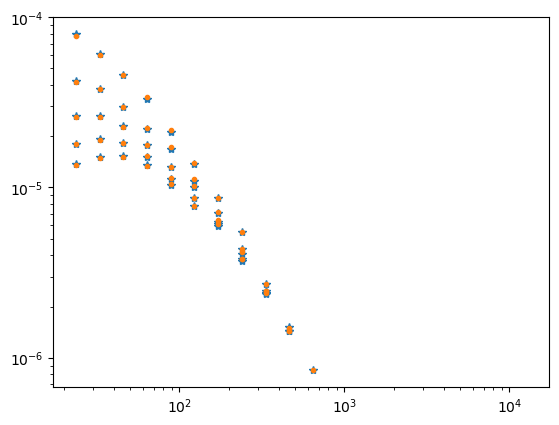

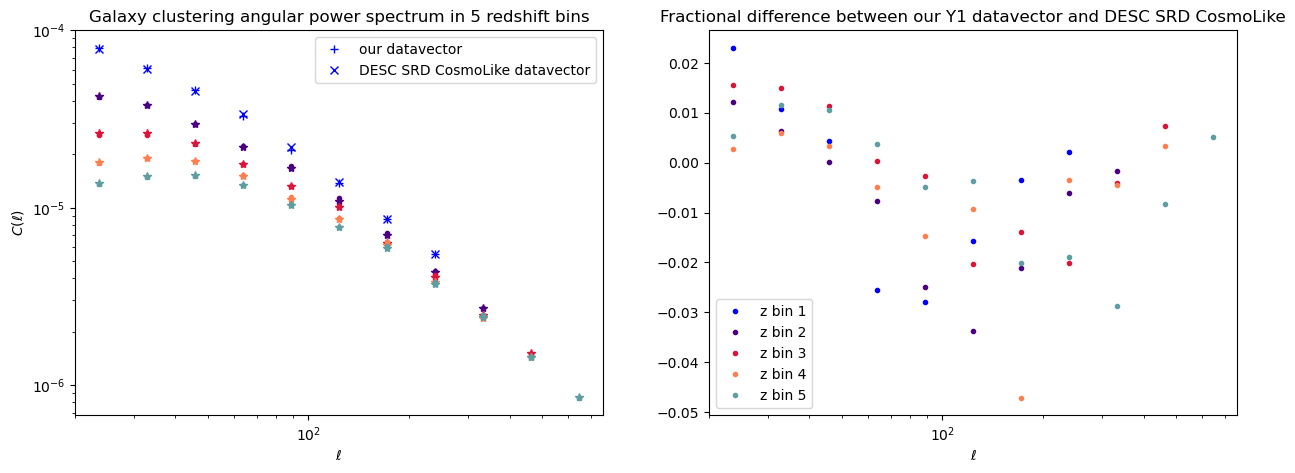

In [8]:
plt.loglog(datavector_y1_fid[:,0], datavector_y1_fid[:,1],  '*' )
plt.loglog(datavector_y1_fid[:,0], lss_y1_cosmolike[:,1],  '.')
plt.show()

nbinz=5
nbin_ell=20
colors=['blue', 'indigo', 'crimson', 'coral', 'cadetblue']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for i in range(nbinz):
    i1 = i*nbin_ell
    num_nonzero=np.sum(datavector_y1_fid[i1:i1+nbin_ell,1]>0)
    i2=i1+num_nonzero
    if i==0:
        ax1.loglog(datavector_y1_fid[i1:i2,0], datavector_y1_fid[i1:i2,1],  '+', color=colors[i], label='our datavector')
        ax1.loglog(datavector_y1_fid[i1:i2,0], lss_y1_cosmolike[i1:i2,1],  'x', color=colors[i], label='DESC SRD CosmoLike datavector')
    else:
        ax1.loglog(datavector_y1_fid[i1:i2,0], datavector_y1_fid[i1:i2,1],  '*', color=colors[i])
        ax1.loglog(datavector_y1_fid[i1:i2,0], lss_y1_cosmolike[i1:i2,1],  '.', color=colors[i])


    ax2.plot(datavector_y1_fid[i1:i2,0], (datavector_y1_fid[i1:i2,1]-lss_y1_cosmolike[i1:i2,1])/datavector_y1_fid[i1:i2,1], marker='.', linestyle='none', color=colors[i], label='z bin '+str(1+i))
ax1.legend()
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$C(\ell)$')
ax1.set_title('Galaxy clustering angular power spectrum in 5 redshift bins')
plt.legend()
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.title('Fractional difference between our Y1 datavector and DESC SRD CosmoLike')
plt.show()